In [1]:
from mlcolvar.cvs import MultiTaskCV
from mlcolvar.cvs import AutoEncoderCV
from mlcolvar.core.loss import TDALoss

import torch
#torch.set_default_dtype(torch.float32)
# Set seed for reproducibility
torch.manual_seed(42)

In [3]:
import numpy as np
!cat state_M ts_data/all_data state_A > combined
l = np.loadtxt('combined')
np.savetxt('combined_new',l,fmt='%0.4f')
!echo -e "#! FIELDS time d1 d2 d3 d4 d5\n$(cat combined_new)" > combined_new

In [4]:
from mlcolvar.data import DictModule
from mlcolvar.core.transform import Normalization
from mlcolvar.core.transform.utils import Statistics
from mlcolvar.utils.fes import compute_fes
from mlcolvar.utils.io import create_dataset_from_files, load_dataframe
from mlcolvar.utils.plot import muller_brown_potential_three_states, plot_isolines_2D, plot_metrics, paletteFessa
from mlcolvar.utils.trainer import MetricsCallback

# load unlabeled data
filenames = [ "combined_new"]
path_dataset, path_df = create_dataset_from_files(filenames,return_dataframe=True,
                                                  filter_args={'regex':'d'}, verbose=False,start=0,stop=10000000
                                                  ,stride=1)

# load labeled data
filenames = [ "state_M" , "state_A" ]
state_dataset, state_df = create_dataset_from_files(filenames,return_dataframe=True,
                                                    filter_args={'regex':'d'}, verbose=False,start=0,stop=100000,
                                                    stride=1)

# create multitask datamodule with both datasets
datamodule = DictModule(dataset=[path_dataset, state_dataset])
datamodule

DictModule(dataset -> [DictDataset( "data": [6178, 5] ), DictDataset( "data": [4000, 5], "labels": [4000] )],
		     train_loader -> DictLoader(length=0.8, batch_size=0, shuffle=True),
		     valid_loader -> DictLoader(length=0.2, batch_size=0, shuffle=True))

In [5]:
import torch

class AutoencoderPath(AutoEncoderCV):
  def __init__(self,**kwargs):
    super().__init__(**kwargs)

  def forward(self,x):
    s = super().forward(x)
    x_hat = super().encode_decode(x)
    loss = torch.nn.MSELoss(reduction='none') 
    z = torch.linalg.norm(loss(x,x_hat) , dim=-1)
    return torch.hstack([s,z.unsqueeze(dim=-1)])


In [6]:
n_states=2

nn_args = {'activation': 'shifted_softplus'}
options= {'encoder': nn_args, 'decoder': nn_args }

main_cv = AutoencoderPath(encoder_layers=[5,15,15,1] , options=options)
aux_loss_fn = TDALoss(n_states, [-5, 5], [0.2, 0.2])
model = MultiTaskCV(main_cv, auxiliary_loss_fns=[aux_loss_fn], loss_coefficients=[5e-2])

stat = Statistics()
stat(path_dataset['data'])
stat(state_dataset['data'])
model.norm_in.set_from_stats(stat)
#model = model.float(); model.to("mps")

model.optimizer_kwargs = {'weight_decay' : 1e-8, 'lr' : 5e-3 }
#model.optimizer_kwargs = {'lr' : 1e-2 }
#model.to('cpu')
model

MultiTaskAutoencoderPath(
  (loss_fn): MSELoss()
  (norm_in): Normalization(in_features=5, out_features=5, mode=mean_std)
  (encoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=5, out_features=15, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=15, out_features=15, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=15, out_features=1, bias=True)
    )
  )
  (decoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=1, out_features=15, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=15, out_features=15, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=15, out_features=5, bias=True)
    )
  )
  (auxiliary_loss_fns): ModuleList(
    (0): TDALoss()
  )
)

In [7]:
from lightning import Trainer
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_total_loss", patience=20, min_delta=1e-3)

# define trainer
trainer = Trainer(callbacks=[metrics, early_stopping], logger=None, enable_checkpointing=False, max_epochs=500)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ray-lab3/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [8]:
torch.set_float32_matmul_precision('medium')
#device = torch.device("cpu")
trainer.fit( model, datamodule )

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name               | Type          | Params | Mode  | In sizes | Out sizes
------------------------------------------------------------------------------------
0 | loss_fn            | MSELoss       | 0      | train | ?        | ?        
1 | norm_in            | Normalization | 0      | train | [1, 5]   | [1, 5]   
2 | encoder            | FeedForward   | 346    | train | [1, 5]   | [1, 1]   
3 | decoder            | FeedForward   | 350    | train | [1, 1]   | [1, 5]   
4 | auxiliary_loss_fns | ModuleList    | 0      | train | ?        | ?        
------------------------------------------------------------------------------------
696       Trainable params
0         Non-trainable params
696       Total params
0.003     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/home/ray-lab3/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1235. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/ray-lab3/.local/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

/home/ray-lab3/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4943. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

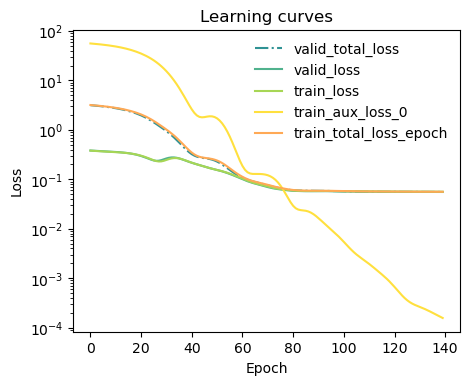

In [9]:
from mlcolvar.utils.plot import plot_metrics

ax = plot_metrics(metrics.metrics,
                  keys=['valid_total_loss','valid_loss','train_loss', 'train_aux_loss_0', 'train_total_loss_epoch'],
                  linestyles=['-.','-','-','-','-'], colors=['fessa1','fessa2','fessa3','fessa4','fessa5'],
                  yscale='log')

In [23]:
model.to_torchscript(file_path="multitask_round_metad_1.ptc", method="trace")

/home/ray-lab3/.local/lib/python3.10/site-packages/mlcolvar/core/nn/utils.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  sp0 = F.softplus(torch.zeros(1), self.beta, self.threshold).item()


MultiTaskAutoencoderPath(
  original_name=MultiTaskAutoencoderPath
  (loss_fn): MSELoss(original_name=MSELoss)
  (norm_in): Normalization(original_name=Normalization)
  (encoder): FeedForward(
    original_name=FeedForward
    (nn): Sequential(
      original_name=Sequential
      (0): Linear(original_name=Linear)
      (1): Shifted_Softplus(original_name=Shifted_Softplus)
      (2): Linear(original_name=Linear)
      (3): Shifted_Softplus(original_name=Shifted_Softplus)
      (4): Linear(original_name=Linear)
    )
  )
  (decoder): FeedForward(
    original_name=FeedForward
    (nn): Sequential(
      original_name=Sequential
      (0): Linear(original_name=Linear)
      (1): Shifted_Softplus(original_name=Shifted_Softplus)
      (2): Linear(original_name=Linear)
      (3): Shifted_Softplus(original_name=Shifted_Softplus)
      (4): Linear(original_name=Linear)
    )
  )
  (auxiliary_loss_fns): ModuleList(
    original_name=ModuleList
    (0): TDALoss(original_name=TDALoss)
  )
)